<a href="https://colab.research.google.com/github/rezoo/movis/blob/colab/Quickstart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Movis: Video Editing as a Code

This Jupyter notebook goes through the basic usage of Movis.

- Install Movis
- Write a simple python script that generates a video with a background and a text
- Write a bit practical python script that concatenates a title logo and a video

### Install movis

In [1]:
pip install git+https://github.com/rezoo/movis.git

  Cloning https://github.com/rezoo/movis.git to /tmp/pip-req-build-pltf9_1w
  Running command git clone --filter=blob:none --quiet https://github.com/rezoo/movis.git /tmp/pip-req-build-pltf9_1w
  Resolved https://github.com/rezoo/movis.git to commit 99c77751305231b3678e2300e8ded1d35ccb32a3
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
import os

import movis as mv
from PIL import Image

# It has been found that errors occur when using PySide only on Google colab.
# To avoid this, we explicitly set an environment variable.
os.environ['QT_QPA_PLATFORM'] = 'offscreen'

Now let's make a simple video.

In [3]:
w, h = 960, 540

title = mv.layer.Composition(size=(w, h), duration=4.0)

title.add_layer(mv.layer.Rectangle(title.size, color='seagreen'), 'bg')
title.add_layer(
    mv.layer.Text('Big Buck Bunny', font_size=60.0, font_family='Liberation Sans', color='#ffffff'),
    name='title',
    position=(w / 2, h / 2))
title.add_layer(
    mv.layer.Text('By Blender Foundation', font_size=20.0, font_family='Liberation Sans', color='#ffffff'),
    name='subtitle',
    position=(w / 2, h / 2 + 50))

LayerItem(name='subtitle', layer=<movis.layer.drawing.Text object at 0x78ed47e94910>, transform=Transform(ap=[0. 0.], pos=[480. 320.], s=[1. 1.], rot=[0.], op=[1.], blend=BlendingMode.NORMAL), offset=0.0, visible=True)

By converting an ``ndarray`` to a ``PIL.Image``, you can view the image directly in the Notebook. In this case, we are outputting a still image at the ``0.0`` second.

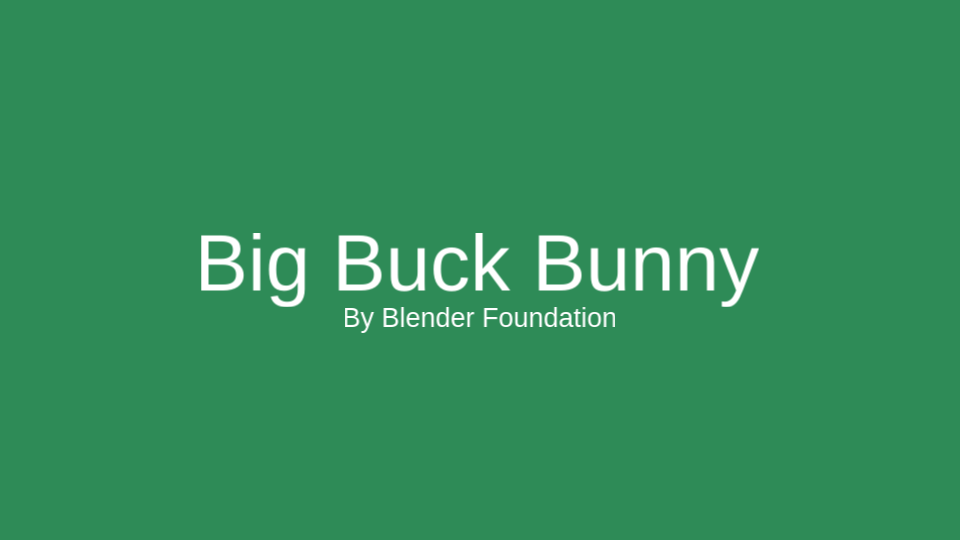

In [4]:
Image.fromarray(title(0.0))

Let's try adding an animation. The target layer includes common attributes such as position, scale, and opacity. By adding keyframes to these attributes, you can animate them.

In [5]:
# Easings define the easing between keyframes. "ease_out{N}" refers to an ease-out animation.
# The larger the value of N, the more abrupt the animation transition will be.
title['title'].scale.enable_motion().extend(
    keyframes=[0.0, 1.5],
    values=[0.0, 1.0],
    easings=['ease_out8'],
)
title['title'].opacity.enable_motion().extend(
    keyframes=[0.0, 1.5],
    values=[0.0, 1.0],
)

p = title['subtitle'].position.init_value
title['subtitle'].position.enable_motion().extend(
    keyframes=[0.5, 1.5],
    values=[(p[0], p[1] + 10), p],
    easings=['ease_out8']
)
title['subtitle'].opacity.enable_motion().extend(
    keyframes=[0.5, 1.5],
    values=[0.0, 1.0]
)

For a preview on IPython Notebook, use `render_and_play()`. The `preview_level` defines the resolution of the output video. For instance, if `preview_level=2`, the resolution will be halved.

In [6]:
title.render_and_play(preview_level=1)

100%|██████████| 120/120 [00:03<00:00, 33.90it/s]


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x00W\xe0mdat\x00\x…

It does not look bad.

Next, download the video itself. Let's use the video provided by Blender foundation.

In [7]:
!curl -O https://commondatastorage.googleapis.com/gtv-videos-bucket/sample/BigBuckBunny.mp4

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  150M  100  150M    0     0   115M      0  0:00:01  0:00:01 --:--:--  115M


In [8]:
video = mv.layer.Video('./BigBuckBunny.mp4')

For example, if you want to see a picture of the video layer after 10 seconds, you can simply use the following:

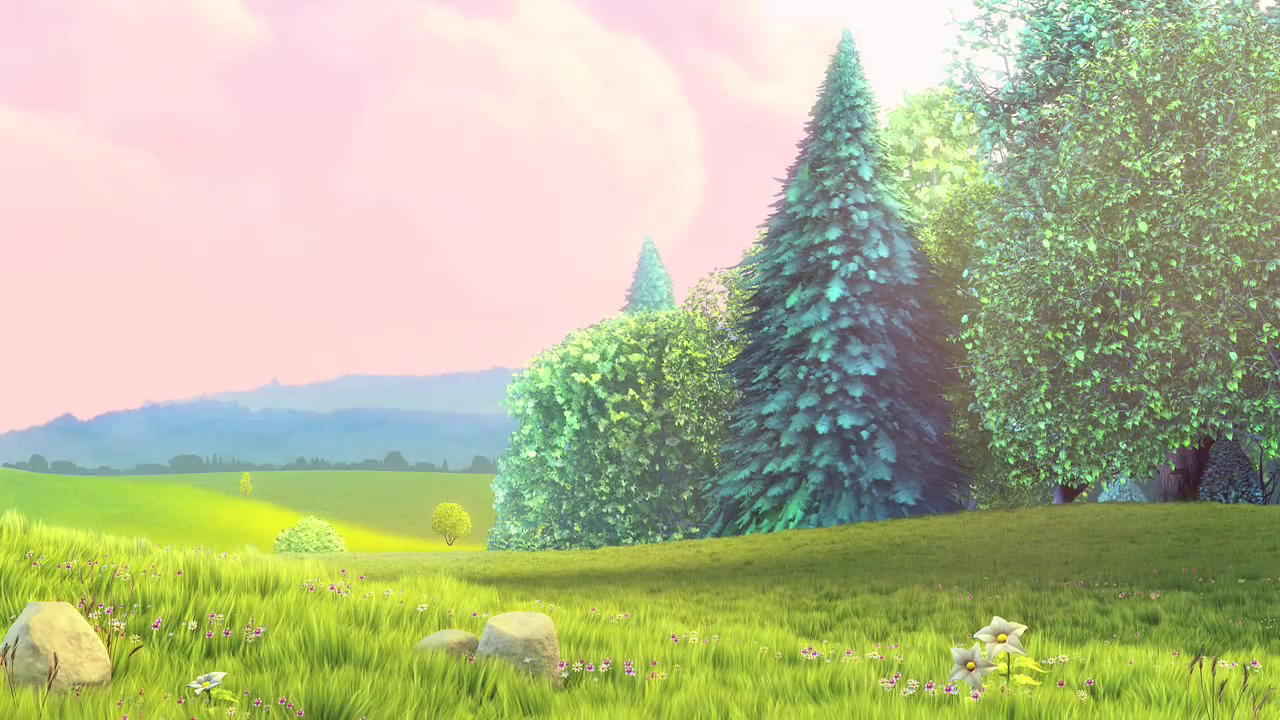

In [9]:
frame = video(10.0)
Image.fromarray(frame)

In this case, the resolution of the video is relatively small, so it must be scaled down by a reasonable value.

In [10]:
scale = w / frame.shape[1]

scene = mv.layer.Composition(size=(w, h), duration=15.0)
scene.add_layer(
    video, name='content', scale=scale)

LayerItem(name='content', layer=<movis.layer.media.Video object at 0x78ed12f5b4f0>, transform=Transform(ap=[0. 0.], pos=[480. 270.], s=[0.75 0.75], rot=[0.], op=[1.], blend=BlendingMode.NORMAL), offset=0.0, visible=True)

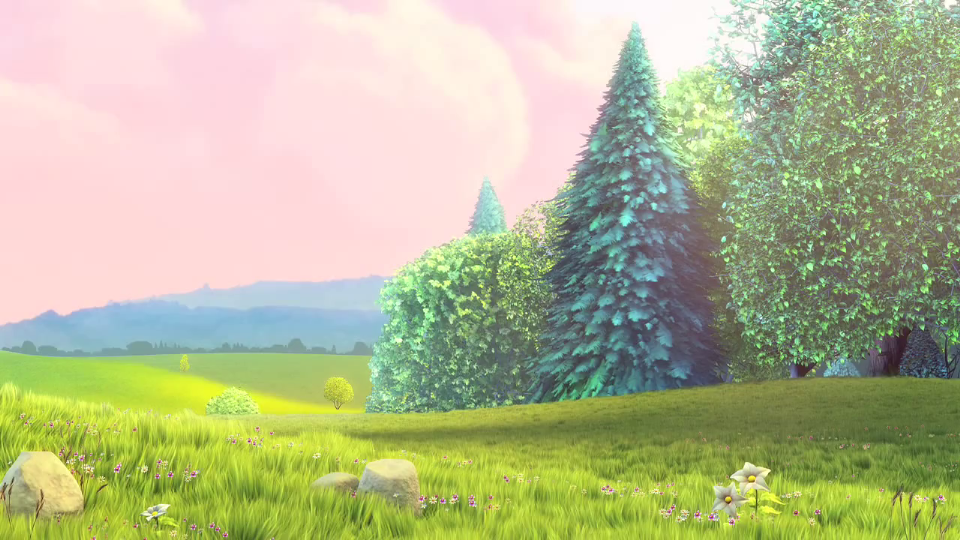

In [11]:
Image.fromarray(scene(10.0))

It appears to have been scaled down correctly.

Next, composite the title and the body of the video. For simplicify, in this case we will create a video that is only 15 seconds long.

In [12]:
scene = mv.layer.Composition(size=(w, h), duration=15.0)
scene.add_layer(video, name='content', scale=scale, offset=4.0)
scene.add_layer(title, name='title')

p = scene['title'].position.init_value
scene['title'].position.enable_motion().extend(
    keyframes=[3.0, 4.0], values=[p, (p[0] + w, p[1])], easings=['ease_in8']
)
scene.render_and_play(preview_level=2)

100%|██████████| 450/450 [00:17<00:00, 25.59it/s]


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x07\xe1:mdat\x00\x…

Looks good. Finally, we output these videos using `scene.write_video()`.

Note here that we explicitly specify `audio=True` to include audio in the videos (movis does not output audio by default)

In [13]:
scene.write_video('output.mp4', audio=True)

/usr/local/lib/python3.10/dist-packages/movis/layer/media.py:358: FutureWarning: PySoundFile failed. Trying audioread instead.
	Audioread support is deprecated in librosa 0.10.0 and will be removed in version 1.0.
  duration = librosa.get_duration(path=str(self._audio_file))
/usr/local/lib/python3.10/dist-packages/movis/layer/media.py:336: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, _ = librosa.load(str(self._audio_file), sr=AUDIO_SAMPLING_RATE, mono=False)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
100%|██████████| 450/450 [00:32<00:00, 13.90it/s]


Movis can create more sophisticated animations in videos by using a variety of compositions and effects. For more details, please refer to the [Examples on GitHub](https://github.com/rezoo/movis/tree/main/examples).